In [1]:
import time as tm
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from scipy.special import comb
from scipy.misc import derivative
from scipy import integrate, interpolate

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities
from chainconsumer import ChainConsumer

In [2]:
### Define all the constants 
c      = 299792.458           #km/s
GN     = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc    = 3.086e19     # km

cosmo_params = {
     'OmegaM' : 0.2999,
     'OmegaDE': 0.7,
     'OmegaR' : 1.e-4,
     'h'     : 0.7,
 }

#GW150914 parameters
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

time = 2*365*24*3600    # time before merger in sec
tc   = 0
psic = 0

In [3]:
#Read in and interpolate LIGO and LISA PSDs.
ligo_asd    = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [4]:
def numerical_derivative(func, par, dx, conv=5e-2, factor=.5, verbose=False):
    
    ratio   = 1e8
    r_best  = 1e8
    dx_best = 0.
    
    while ratio > conv:
        d1    = derivative(func, par, dx=dx/2, order=5)
        d2    = derivative(func, par, dx=dx *2, order=5)
        
        ld1   = len(d1)
        prod  = d1 *d2
        
        d1    = d1[prod != 0]
        d2    = d2[prod != 0]
        
        r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )
        
        if len(r_vec) < int(ld1/3):
            ratio = 1e6
        else:
            ratio = np.mean(r_vec)
        
        if ratio < r_best:
            dx_best = dx
            r_best  = ratio
        
        dx *= factor  
        
        if dx < 1e-15:
            #print(par, dx)
            #raise ValueError('No convergence')
            ratio = 1e-1 *conv
    
    print('Ratio best = %.2e for dx = %.2e' % (r_best, dx_best))
    return derivative(func, par, dx=dx_best, order=5)

Ratio best = 4.09e-02 for dx = 1.95e-03
[ 1.00000000e+00 -2.08764193e-07  4.98308436e-07  3.55311596e-07
 -1.41230329e-07 -3.54450171e-03 -1.48430489e-07  3.78631852e-07
  1.62832159e-07 -7.26039542e-08 -1.23667634e-04 -9.71441070e-08
  2.32874800e-07  6.39826918e-08 -3.12401408e-08 -1.17328119e-05
 -5.80412634e-08  7.44647312e-08  1.94597676e-08 -9.34902149e-09
 -1.42695424e-06 -3.10808661e-08 -8.45436579e-08  2.92319307e-09
 -6.40438425e-11 -1.48424216e-07 -1.44295629e-08 -2.33601537e-07
 -1.22174827e-09  2.21755301e-09 -1.01623219e-09 -5.47102973e-09
 -3.63773821e-07 -1.14500049e-09  1.59275015e-09  4.55016496e-09
 -1.50406041e-09 -4.67818115e-07 -4.11593166e-10  5.48955498e-10
  9.80583814e-10 -2.24229043e-10 -5.40250413e-07 -5.44466494e-11
  5.94189755e-11  4.44198597e-11 -6.78270994e-12 -5.77391117e-07
 -6.44434890e-13  4.87021424e-13  4.87793493e-13 -6.97267117e-13
 -5.77391121e-07 -6.78270994e-12  4.44079797e-11  5.94189755e-11
 -5.43722138e-11 -5.40250413e-07 -2.23970488e-10  

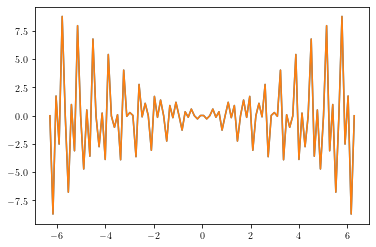

In [5]:
# Just a test of my function to compute derivatives
a_val    = 10
b_val    = 6
x        = np.linspace(-2 *np.pi, 2 * np.pi, 100)
my_func  = lambda a : np.sin(a * x)**b_val

analytic = b_val *x *np.cos(a_val *x) *np.sin(a_val * x)**(b_val -1)
dsin     = numerical_derivative(my_func, a_val, 1) 

plt.plot(x, dsin)
plt.plot(x, analytic)

print( (dsin -analytic ) / dsin )

In [120]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_der(farr, pars, cosmo_params, which_wf='GR', MG_flag=False, width=0, dist_corr=True):
    t0 = tm.perf_counter()

    waveform = utilities.waveform_delta(cT_type=which_wf, width=width).h_Delta_exact
    
    if dist_corr==False:
        hf = waveform(farr, pars, cosmo_params, dist_corr=False)
    else:      
        hf = waveform(farr, pars, cosmo_params)
    
    Mz = np.exp(pars[0]) * Msolar * GN/ (1e3 *c)**3
    eta = np.exp(pars[1])
    zem = np.exp(pars[2])
    tc = pars[3]
    psic = pars[4]
    c0 = pars[5]
    fstar = pars[6]

    # Function to compute numerical derivatives w.r.t. lnM
    dlnA_dlnMz_to_der = lambda lnMz_func: np.log(utilities.amp_Delta_exact(farr, fstar, c0, np.exp(lnMz_func) * Msolar * GN/ (1e3 *c)**3,
                     eta, zem, cosmo_params, cT_type=which_wf, width=width))

    dPsi_dlnMz_to_der = lambda lnMz_func: utilities.Psi_Delta_exact(farr, fstar, c0, np.exp(lnMz_func) * Msolar * GN/ (1e3 *c)**3, 
                    eta, zem, cosmo_params, tc, psic, cT_type=which_wf, width=width)

    # Function to compute numerical derivatives w.r.t. lneta
    dlnA_dlneta_to_der = 0

    dPsi_dlneta_to_der = lambda lneta_func: utilities.Psi_Delta_exact(farr, fstar, c0, Mz, 
                    np.exp(lneta_func), zem, cosmo_params, tc, psic, cT_type=which_wf, width=width)

    # Function to compute numerical derivatives w.r.t. lnz
    dlnA_dlnzem_to_der = lambda lnzem_func: np.log(utilities.amp_Delta_exact(farr, fstar, c0, Mz,
                    eta, np.exp(lnzem_func), cosmo_params, cT_type=which_wf, width=width))
    
    dPsi_dlnzem_to_der = 0

    # Function to compute numerical derivatives w.r.t. c0
    dlnA_dc0_to_der = lambda c0_func: np.log(utilities.amp_Delta_exact(farr, fstar, c0_func, Mz,
                     eta, zem, cosmo_params, cT_type=which_wf, width=width))

    dPsi_dc0_to_der = lambda c0_func: utilities.Psi_Delta_exact(farr, fstar, c0_func, Mz, 
                    eta, zem, cosmo_params, tc, psic, cT_type=which_wf, width=width)

    #Distance correlation term in the phase
    if dist_corr == True:
        dPsi_dist_dlnzem_to_der = lambda lnzem_func: utilities.Psi_dist_corr(farr, fstar, c0, np.exp(lnzem_func), cosmo_params)
        dPsi_dist_dc0_to_der = lambda c0_func: utilities.Psi_dist_corr(farr, fstar, c0_func, zem, cosmo_params)

    # Analytical derivetives w.r.t. tc and psic
    dh_dtc      = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)
    dh_dpsic    = -1.j*waveform(farr, pars, cosmo_params)
    
    dlnA_to_der = [dlnA_dlnMz_to_der, dlnA_dlneta_to_der, dlnA_dlnzem_to_der, dlnA_dc0_to_der]
    dPsi_to_der = [dPsi_dlnMz_to_der, dPsi_dlneta_to_der, dPsi_dlnzem_to_der, dPsi_dc0_to_der]

    derivatives = []
    verbose     = False
    
    for i in range(0, len(pars)-1):
        print('- Working on index', i)
        dx = np.abs(.1 *pars[i]) if pars[i] != 0 else 1e-1

        if i == 3:
            derivatives.append(dh_dtc)
        elif i == 4:
            derivatives.append(dh_dpsic)
        elif i == 5:
            if MG_flag:
                dlnA_der = numerical_derivative(dlnA_to_der[-1], pars[i], dx=dx, verbose=verbose)
                if dist_corr == True:
                    dPsi_dist_dc0_der = numerical_derivative(dPsi_dist_dc0_to_der, pars[i], dx=dx, verbose=verbose)
                    derivatives.append((dlnA_der + 1.j*dPsi_dist_dc0_der) *hf)  
                else:
                    derivatives.append((dlnA_der) *hf)
        else:
            if i == 1:
                dlnA_der = 0
            else:
                dlnA_der = numerical_derivative(dlnA_to_der[i], pars[i], dx=dx, verbose=verbose)
            if i == 2:
                if dist_corr == True:
                    dPsi_dist_dlnzem_der = numerical_derivative(dPsi_dist_dlnzem_to_der, pars[i], dx=dx, verbose=verbose)
                    derivatives.append((dlnA_der + 1.j*dPsi_dist_dlnzem_der) *hf)
                else:
                    derivatives.append(dlnA_der *hf)
            else:
                dPsi_der = numerical_derivative(dPsi_to_der[i], pars[i], dx=dx, verbose=verbose)
                derivatives.append((dlnA_der + 1.j*dPsi_der) *hf)
    
    derivatives   = derivatives[:2][::-1] + derivatives[2:]
  
    print('This took %.2f seconds' % (tm.perf_counter() -t0) )

    return derivatives

In [121]:
def Fisher_build(farr, psd, derivatives):

    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]

    connum = np.linalg.cond(Fisher_matrix)
    print('condition number (div by 1e15)',connum/1.e15)

    return Fisher_matrix

In [7]:
# Get mass quantities
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc = utilities.inspiral_fc(Mtot_s)
farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only
f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

Dl_arr = np.array([Dl_s]*len(farr))

In [8]:
print('eta',eta)
print('fc',fc)

eta 0.24710059171597634
fc 67.63181124855085


In [9]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

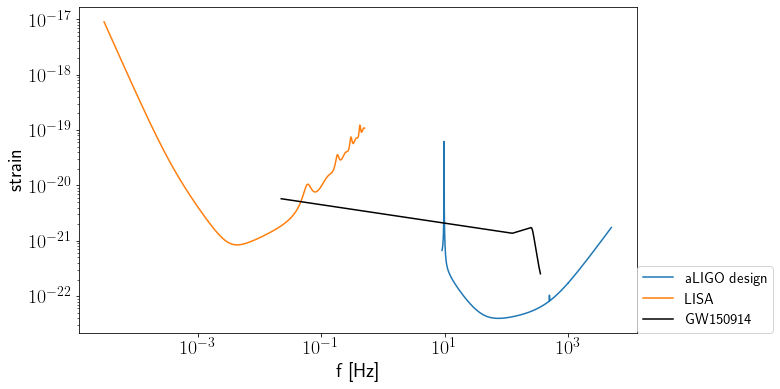

In [10]:
# Plot full IMR GR signal
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0))

In [11]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


In [12]:
# SNR in LISA and LIGO
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR')
print(SNR_ligo)
print('LISA SNR')
print(SNR_lisa)

design LIGO SNR
65.53220995174958
LISA SNR
3.4325121616962133


# GR Constraints

In [123]:
ders_ligo = Fisher_der(farr_ligo, pars_GR, cosmo_params, which_wf='GR', dist_corr=False)
fisher_ligo = Fisher_build(farr_ligo, ligo_psd, ders_ligo)
cov_matrix_ligo = np.linalg.inv(fisher_ligo)
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
Ratio best = 4.89e-05 for dx = 2.41e-01
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.11 seconds
condition number (div by 1e15) 1.3549658527633837e-08
LIGO GR constraints
[0.01955086 0.00265629 0.01452995 0.00056156 0.20065686]


In [124]:
fisher_ligo

array([[ 3.37793160e+05, -1.59720481e+06, -9.58593132e-14,
         4.02236264e+06, -2.41306843e+04],
       [-1.59720481e+06,  8.05425720e+06, -3.79779481e+03,
        -1.42902476e+07,  9.55710296e+04],
       [-9.58593132e-14, -3.79779481e+03,  4.83632923e+03,
        -2.80281898e-12, -3.93799647e-15],
       [ 4.02236264e+06, -1.42902476e+07, -2.80281898e-12,
         3.33114490e+08, -1.13124342e+06],
       [-2.41306843e+04,  9.55710296e+04, -3.93799647e-15,
        -1.13124342e+06,  4.29447054e+03]])

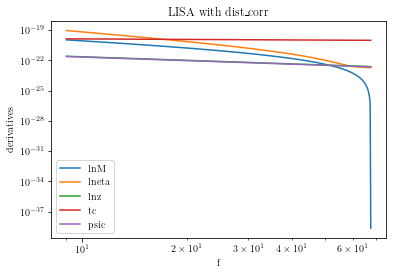

In [125]:
plt.figure()
plt.title('LISA with dist_corr')
plt.loglog(farr_ligo, np.abs(ders_ligo[0]),label='lnM')
plt.loglog(farr_ligo, np.abs(ders_ligo[1]),label='lneta')
plt.loglog(farr_ligo, np.abs(ders_ligo[2]),label='lnz')
plt.loglog(farr_ligo, np.abs(ders_ligo[3]),label='tc')
plt.loglog(farr_ligo, np.abs(ders_ligo[4]),label='psic')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [127]:
ders_lisa = Fisher_der(farr_lisa, pars_GR, cosmo_params, which_wf='GR', dist_corr=False) 
ders_lisa[1] *= 1e-4        # reducing magnitude of dh/dlneta

fisher_lisa = Fisher_build(farr_lisa, lisa_psd, ders_lisa)
cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('LISA GR constraints')
print(pconstraints_lisa)

- Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
Ratio best = 4.89e-05 for dx = 2.41e-01
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.11 seconds
condition number (div by 1e15) 3.01593132075845e-07
LISA GR constraints
[0.04849358 0.07365302 0.27452683 3.65767845 4.49602444]


In [128]:
fisher_lisa

array([[ 7.95728196e+06,  5.73177847e+06,  1.92553697e-14,
        -1.56155680e+03,  8.91782842e+03],
       [ 5.73177847e+06,  4.13410275e+06, -1.04194798e-03,
        -1.16476760e+03,  6.52017785e+03],
       [ 1.92553697e-14, -1.04194798e-03,  1.32687618e+01,
        -3.87879278e-18,  2.33963551e-17],
       [-1.56155680e+03, -1.16476760e+03, -3.87879278e-18,
         6.95922276e-01, -2.49879922e+00],
       [ 8.91782842e+03,  6.52017785e+03,  2.33963551e-17,
        -2.49879922e+00,  1.17821397e+01]])

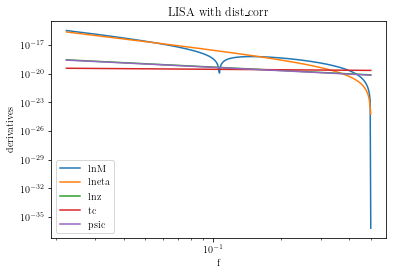

In [129]:
plt.figure()
plt.title('LISA with dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa[4]),label='psic')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [130]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)

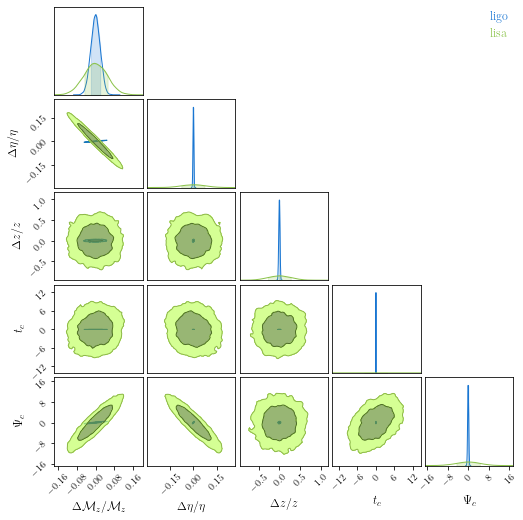

In [131]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR,name='lisa');
cc.plotter.plot();

# Step function

In [79]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.1

In [80]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

Text(0, 0.5, '$\\Delta$')

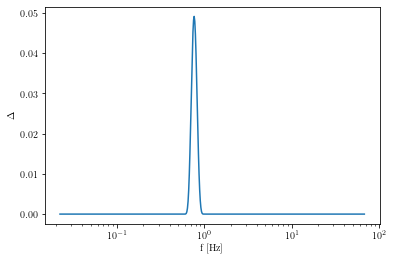

In [81]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [111]:
Psi_dist_lisa = utilities.Psi_dist_corr(farr_lisa, fstar, c0, zem, cosmo_params)

dPsi_dist_dc0_func = lambda c0_func: utilities.Psi_dist_corr(farr_lisa, fstar, c0_func, zem, cosmo_params)
dPsi_dist_dc0 = numerical_derivative(dPsi_dist_dc0_func, 1, dx = 0.1)

Ratio best = 1.33e-15 for dx = 1.00e-01


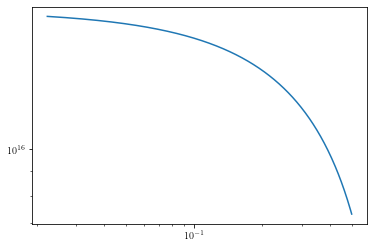

In [112]:
plt.loglog(farr_lisa, np.abs(Psi_dist_lisa))

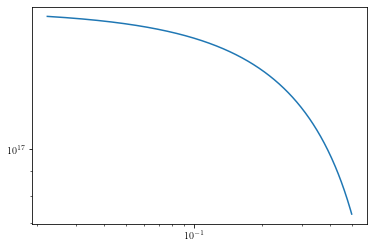

In [113]:
plt.loglog(farr_lisa, np.abs(dPsi_dist_dc0))

In [109]:
dPsi_dist_dlnzem_to_der = lambda lnzem_func: utilities.Psi_dist_corr(farr, fstar, c0, np.exp(lnzem_func), cosmo_params)
dPsi_dist_dlnzem_der = numerical_derivative(dPsi_dist_dlnzem_to_der, zem, dx=0.1)

Ratio best = 3.91e-05 for dx = 1.00e-01


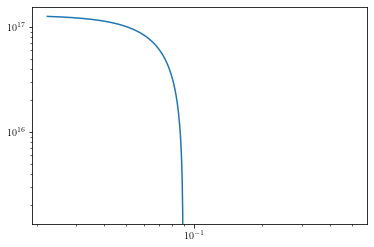

In [110]:
plt.loglog(farr_lisa, np.abs(dPsi_dist_dlnzem_der))

In [85]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

h_Delta_step_w1_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step, cosmo_params)
h_Delta_step_w1_fid_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step_fid, cosmo_params)

h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params,dist_corr=False)

# For plotting only
h_Delta_step_w1_plot = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)

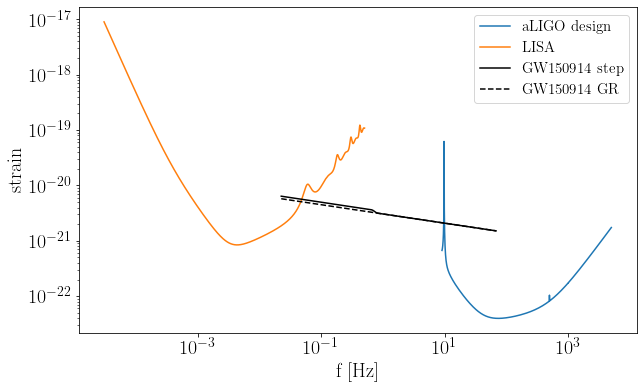

In [86]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1_plot), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('../plots/amp_psd_step.pdf')

In [87]:
#mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
#mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

#ligo_psd = ligo_interp(farr[mask_ligo])**2
#lisa_psd = lisa_interp(farr[mask_lisa])

In [88]:
# SNR for fiducial and non-fiducial models
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1_ligo, h_Delta_step_w1_ligo, ligo_psd, farr_ligo)
SNR_ligo_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid_ligo, h_Delta_step_w1_fid_ligo, ligo_psd, farr_ligo)
SNR_ligo_step = np.sqrt(SNR_ligo_sq)
SNR_ligo_step_fid = np.sqrt(SNR_ligo_sq_fid)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1, h_Delta_step_w1, lisa_psd, farr_lisa)
SNR_lisa_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid, h_Delta_step_w1_fid, lisa_psd, farr_lisa)
SNR_lisa_step = np.sqrt(SNR_lisa_sq)
SNR_lisa_step_fid = np.sqrt(SNR_lisa_sq_fid)

print('LIGO SNR, mod and fiducial')
print(SNR_ligo_step,SNR_ligo_step_fid)
print('LISA SNR, mod and fiducial')
print(SNR_lisa_step,SNR_lisa_step_fid)

LIGO SNR, mod and fiducial
65.53220995174962 65.53220995174962
LISA SNR, mod and fiducial
3.813902401884684 3.4325121616962155


In [138]:
# Constraints for fiducial and non-fiducial models
ders_lisa_step = Fisher_der(farr_lisa, pars_step, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
ders_lisa_step[1] *= 1.e-4       # reducing magnitude of dh/dlneta

fisher_lisa_step = Fisher_build(farr_lisa, lisa_psd, ders_lisa_step)
cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)



- Working on index 0
Ratio best = 1.65e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
Ratio best = 4.89e-05 for dx = 2.41e-01
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 9.00e-02
This took 1.17 seconds
condition number (div by 1e15) 55898868.293240175
LISA step function
mod
[8.84461329e-03 1.22664326e-02 1.71663938e+07 2.21714246e+00
 5.43774533e-01 1.63968613e+07]


In [139]:
fisher_lisa_step

array([[ 9.82380488e+06,  7.07626971e+06,  5.33400569e-14,
        -3.09902483e+02,  1.99815119e+03,  6.28273186e-14],
       [ 7.07626971e+06,  5.10383055e+06, -1.28635553e-03,
        -2.21302385e+02,  1.42629350e+03, -1.34672638e-03],
       [ 5.33400569e-14, -1.28635553e-03,  1.63811875e+01,
         6.98517674e-02, -3.51902543e-01,  1.71499843e+01],
       [-3.09902483e+02, -2.21302385e+02,  6.98517674e-02,
         8.59163303e-01, -3.08493731e+00,  7.31300292e-02],
       [ 1.99815119e+03,  1.42629350e+03, -3.51902543e-01,
        -3.08493731e+00,  1.45458515e+01, -3.68417926e-01],
       [ 6.28273186e-14, -1.34672638e-03,  1.71499843e+01,
         7.31300292e-02, -3.68417926e-01,  1.79548622e+01]])

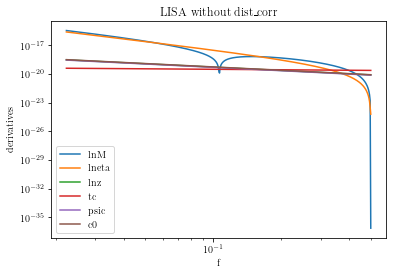

In [140]:
# plot derivatives
plt.figure()
plt.title('LISA without dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()


In [141]:
ders_lisa_step_distcorr = Fisher_der(farr_lisa, pars_step, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)
ders_lisa_step_distcorr[1] *= 1.e-4       # reducing magnitude of dh/dlneta
ders_lisa_step_distcorr[2] *= 1.e-15       # reducing magnitude of dh/dlnz
ders_lisa_step_distcorr[5] *= 1.e-15       # reducing magnitude of dh/dc0

fisher_lisa_step_distcorr = Fisher_build(farr_lisa, lisa_psd, ders_lisa_step_distcorr)
cov_matrix_lisa_step_distcorr = np.linalg.inv(fisher_lisa_step_distcorr)

pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))

print('mod with distcorr')
print(pconstraints_lisa_step_distcorr)

- Working on index 0
Ratio best = 1.65e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
Ratio best = 4.89e-05 for dx = 2.41e-01
Ratio best = 4.57e-04 for dx = 2.41e-01
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 9.00e-02
Ratio best = 9.15e-16 for dx = 9.00e-02
This took 2.63 seconds
condition number (div by 1e15) 2441566.4257189403
mod with distcorr
[0.04364422 0.06628772        nan        nan        nan        nan]


/tmp/ipykernel_136735/789924853.py:9: RuntimeWarning: invalid value encountered in sqrt
  pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))


In [142]:
fisher_lisa_step_distcorr

array([[ 9.82380488e+06,  7.07626971e+06,  2.03119991e+05,
        -1.92784790e+03,  1.10096647e+04, -2.07559713e+06],
       [ 7.07626971e+06,  5.10383055e+06,  1.48400854e+05,
        -1.43798470e+03,  8.04960229e+03, -1.51644544e+06],
       [ 2.03119991e+05,  1.48400854e+05,  4.87881382e+03,
        -5.57017509e+01,  2.66314476e+02, -4.98545312e+04],
       [-1.92784790e+03, -1.43798470e+03, -5.57017509e+01,
         8.59163303e-01, -3.08493731e+00,  5.69192591e+02],
       [ 1.10096647e+04,  8.04960229e+03,  2.66314476e+02,
        -3.08493731e+00,  1.45458515e+01, -2.72135478e+03],
       [-2.07559713e+06, -1.51644544e+06, -4.98545312e+04,
         5.69192591e+02, -2.72135478e+03,  5.09442331e+05]])

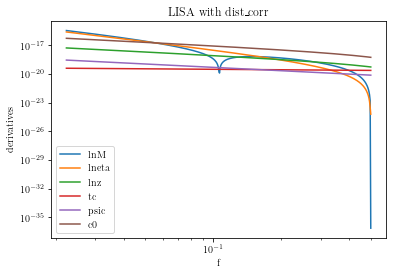

In [143]:
# plot derivatives
plt.figure()
plt.title('LISA with dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [144]:
ders_lisa_step_fid = Fisher_der(farr_lisa, pars_step_fid, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
ders_lisa_step_fid[1] *= 1.e-4       # reducing magnitude of dh/dlneta

fisher_lisa_step_fid = Fisher_build(farr_lisa, lisa_psd, ders_lisa_step_fid)
cov_matrix_lisa_step_fid = np.linalg.inv(fisher_lisa_step_fid)

pconstraints_lisa_step_fid = np.sqrt(np.diag(cov_matrix_lisa_step_fid))

print('fiducial')
print(pconstraints_lisa_step_fid)

- Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
Ratio best = 4.89e-05 for dx = 2.41e-01
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 1.00e-01
This took 1.19 seconds
condition number (div by 1e15) 26391745.629919223
fiducial
[4.84935774e-02 7.36530208e-02 2.23560849e+07 3.65767845e+00
 4.49602444e+00 2.37265664e+07]


In [145]:
fisher_lisa_step_fid

array([[ 7.95728196e+06,  5.73177847e+06,  1.92553697e-14,
        -1.56155680e+03,  8.91782842e+03,  1.84670928e-15],
       [ 5.73177847e+06,  4.13410275e+06, -1.04194798e-03,
        -1.16476760e+03,  6.52017785e+03, -9.81763531e-04],
       [ 1.92553697e-14, -1.04194798e-03,  1.32687618e+01,
        -3.87879278e-18,  2.33963551e-17,  1.25023386e+01],
       [-1.56155680e+03, -1.16476760e+03, -3.87879278e-18,
         6.95922276e-01, -2.49879922e+00,  2.69230290e-18],
       [ 8.91782842e+03,  6.52017785e+03,  2.33963551e-17,
        -2.49879922e+00,  1.17821397e+01, -8.74078024e-18],
       [ 1.84670928e-15, -9.81763531e-04,  1.25023386e+01,
         2.69230290e-18, -8.74078024e-18,  1.17801851e+01]])

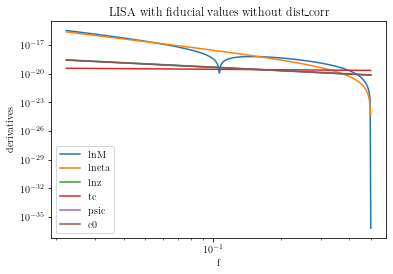

In [146]:
# plot derivatives
plt.figure()
plt.title('LISA with fiducial values without dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [114]:
### Distance correction term disappears for fiducial c0=1

# ders_lisa_step_fid_distcorr, fisher_lisa_step_fid_distcorr = Fisher_det(farr_lisa, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)
# cov_matrix_lisa_step_fid_distcorr = np.linalg.inv(fisher_lisa_step_fid_distcorr)

# pconstraints_lisa_step_fid_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_fid_distcorr))

# print('fiducial with dist corr')
# print(pconstraints_lisa_step_fid_distcorr)

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step_fid = np.linalg.inv(cov_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc = np.array(Fisher_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_fixtc)

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step = np.linalg.inv(cov_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc = np.array(Fisher_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fixtc)

In [ ]:
# Same for uncorrected version
Fisher_matrix_lisa_step_fid_distcorr = np.linalg.inv(cov_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc = np.array(Fisher_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_distcorr_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_distcorr_fixtc)

In [151]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

data = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid, size=20000)
data_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_fixtc, size=20000)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr, size=20000)
data_distcorr_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr_fixtc, size=20000)
data_MG = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step, size=20000)
data_MG_fixtc = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step_fixtc, size=20000)


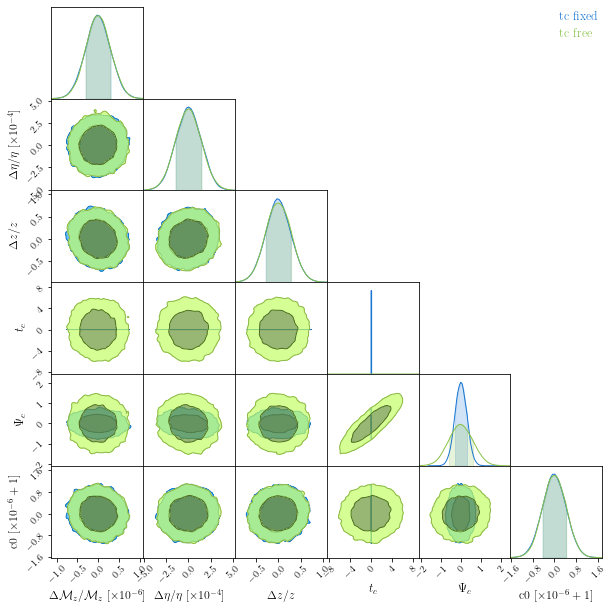

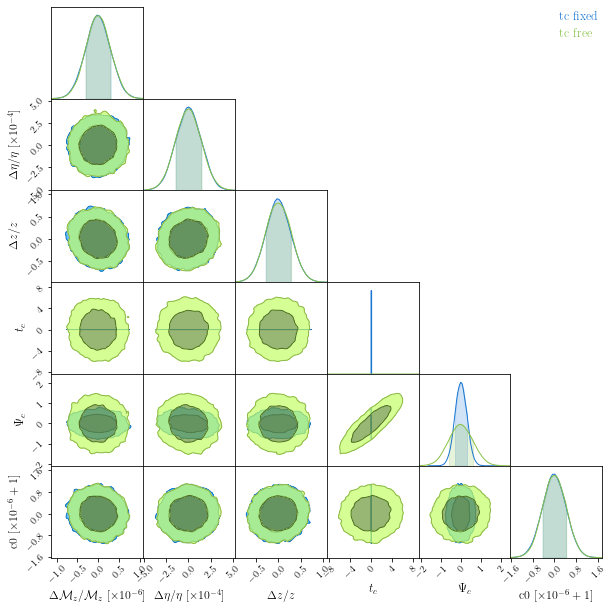

In [142]:
cc = ChainConsumer()
cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();


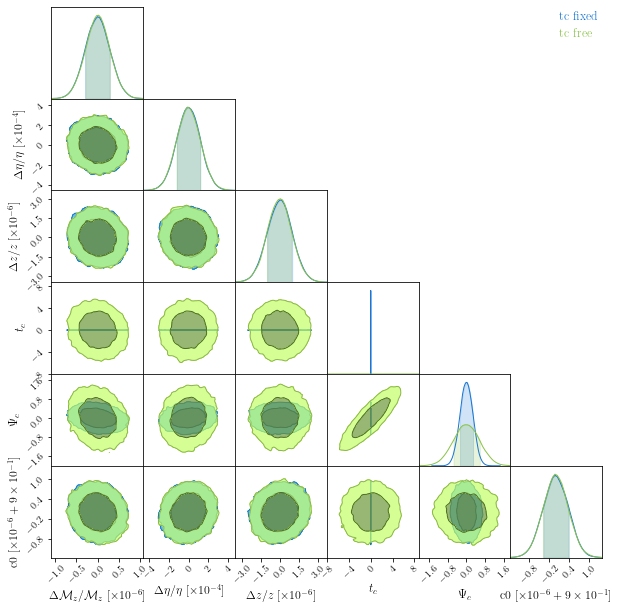

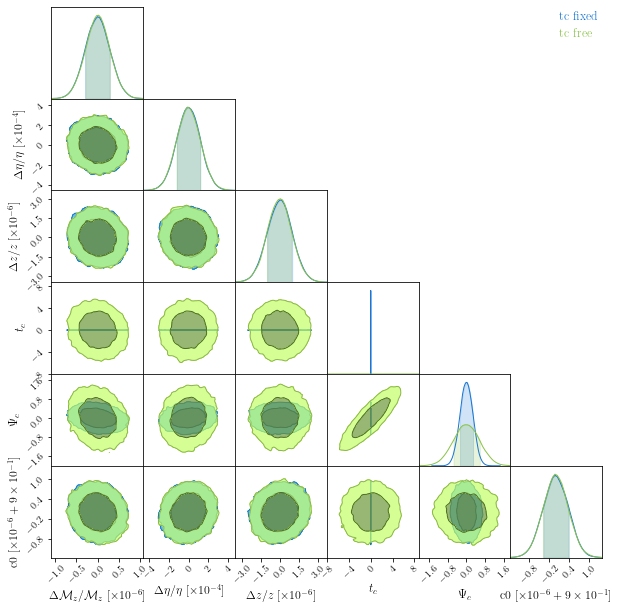

In [152]:
cc = ChainConsumer()
cc.add_chain(data_MG_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data_MG, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();

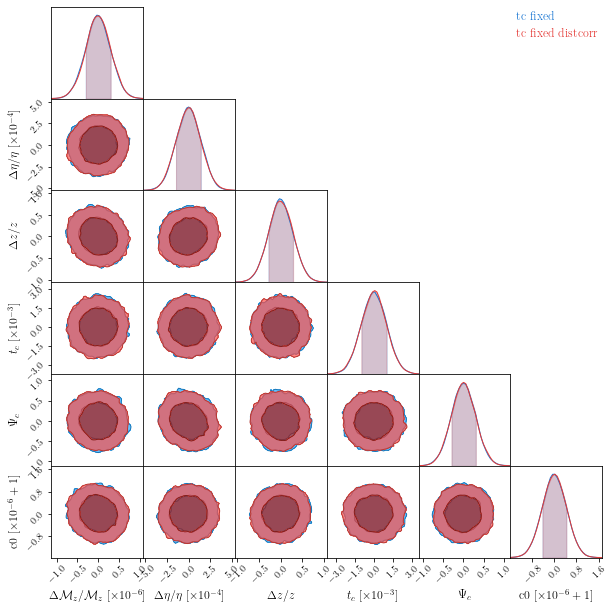

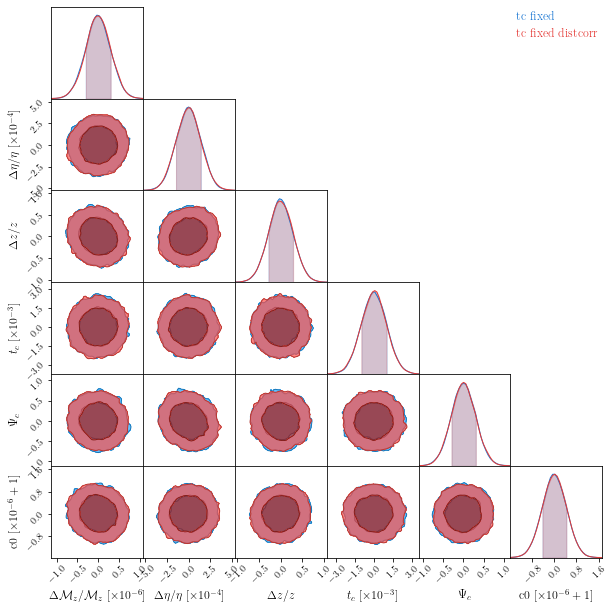

In [143]:
cc = ChainConsumer()

#cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label, name='tc fixed')
cc.add_chain(data_distcorr_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed distcorr',color='r');
cc.plotter.plot();

In [144]:
Psi, Psi_old = utilities.Psi_Delta_exact(farr, fstar, c0, Ms, eta, zem, cosmo_params, tc, psic, cT_type='step', width=w1)

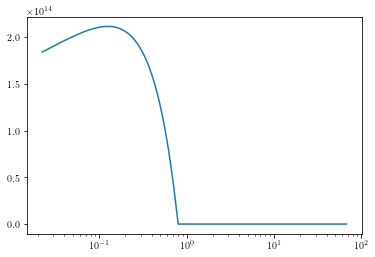

In [145]:
plt.semilogx(farr,abs(Psi/Psi_old))

In [127]:
cc.remove_chain('tc fixed')
cc.remove_chain('tc fixed distcorr')